In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
import numpy as np

# **Reading file**

In [2]:
df = pd.read_csv('../data/Cancer_data.csv')

### **Type casting and cleaning**

In [3]:
df = df.drop('Unnamed: 32',axis=1)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0}).astype('int8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int8   
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### **Checking for NaN**

In [5]:
df.isna().sum().mean()

0.0

### No duplicate ids

In [6]:
df.id.nunique(), df.shape[0]

(569, 569)

### **Features and target**

In [7]:
features = df.drop(['id','diagnosis'], axis=1)
target = df['diagnosis']

### **Classes Percentage**

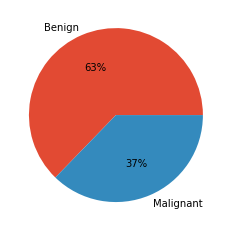

In [10]:
plt.pie(target.value_counts(), labels=['Benign', 'Malignant'], autopct='%.0f%%');

### **Removing outliers**

In [11]:
def drop_out_of_quantile(column):
    lower = column.quantile(.1)
    upper = column.quantile(.9)

    column = column.where((column < upper) & (column > lower))

    

In [12]:
for column_name in features:
    
    column = features[column_name]

    lower = column.quantile(.01)
    upper = column.quantile(.99)

    features[column_name] = column.where((column < upper) & (column > lower))

In [13]:
features = features.dropna()
target = target.iloc[features.index]

### **Removing low correlation features**

In [14]:
feat_corr = df.corr()[2:]['diagnosis']
top_features = feat_corr[(feat_corr > .1) | (feat_corr < -.1)]
top_features = features.loc[:, top_features.index]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(features, target, test_size=.2)

### **Random Forest all features**

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train, y_train)

print(classification_report(y_pred=rf.predict(X_test), y_true=y_test))

cv_results = cross_validate(rf, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.95      0.93      0.94        41

    accuracy                           0.94        89
   macro avg       0.94      0.94      0.94        89
weighted avg       0.94      0.94      0.94        89

10 Fold Cross validation mean f1 : 0.9497421798631477


### **Random Forest top features**

In [17]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train_top, y_train_top)

print(classification_report(y_pred=rf.predict(X_test_top), y_true=y_test_top))
cv_results = cross_validate(rf, X=top_features, y=target, cv=10,scoring='f1')

print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.94      0.97      0.95        30

    accuracy                           0.97        89
   macro avg       0.96      0.97      0.96        89
weighted avg       0.97      0.97      0.97        89

10 Fold Cross validation mean f1 : 0.9495711143695015


### **XGBoost all features**

In [18]:
from xgboost import XGBClassifier

scale_pos_weight = (target == False).sum()/(target == True).sum()

xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=rf.predict(X_test)))

cv_results = cross_validate(xgb, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.98      0.99        41

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89

10 Fold Cross validation mean f1 : 0.9741739980449658


### **XGBoost top features**

In [19]:
xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train_top, y_train_top)
print(classification_report(y_true=y_test_top, y_pred=rf.predict(X_test_top)))

cv_results = cross_validate(xgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.94      0.97      0.95        30

    accuracy                           0.97        89
   macro avg       0.96      0.97      0.96        89
weighted avg       0.97      0.97      0.97        89

10 Fold Cross validation mean f1 : 0.9745906647116325


In [21]:
features

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.54,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.2,706.7,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.29,29.41,179.1,1819.0,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.45,26.40,166.1,2027.0,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637


In [20]:
top_features

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,radius_se,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.5435,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.7456,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.7572,...,22.54,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.3345,...,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.4467,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.3645,...,15.30,33.17,100.2,706.7,0.1241,0.2264,0.1326,0.1048,0.2250,0.08321
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.9622,...,24.29,29.41,179.1,1819.0,0.1407,0.4186,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,1.1760,...,25.45,26.40,166.1,2027.0,0.1410,0.2113,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.7655,...,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637


### **Grid Search**

In [19]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [20, 60, 100],
    "max_depth": [ 2, 5],
    "max_leaves":[0, 2, 5],
    "learning_rate":[.1, .01, .5],
    "verbosity": [1],
    "objective": ['binary:logistic'],
    "n_jobs": [-1],
    "scale_pos_weight": [None, scale_pos_weight, np.sqrt(scale_pos_weight)]
}
grid = GridSearchCV(XGBClassifier(), 
                    param_grid=params,
                    cv=10, 
                    scoring='f1')


In [20]:
grid.fit(X_train_top, y_train_top)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                         

In [21]:
best_xgb = XGBClassifier(**grid.best_params_)

In [22]:
cv_results = cross_validate(best_xgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

10 Fold Cross validation mean f1 : 0.9683406647116325


### **LightGBM all features**

In [23]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(class_weight='balanced')

lgb.fit(X_train, y_train)

print(classification_report(y_true=y_test, y_pred=rf.predict(X_test)))

cv_results = cross_validate(lgb, X=features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.94      0.97      0.96        33

    accuracy                           0.97        89
   macro avg       0.96      0.97      0.96        89
weighted avg       0.97      0.97      0.97        89

10 Fold Cross validation mean f1 : 0.970733137829912


In [24]:
lgb.fit(X_train_top, y_train_top)

print(classification_report(y_true=y_test_top, y_pred=rf.predict(X_test_top)))

cv_results = cross_validate(lgb, X=top_features, y=target, cv=10,scoring='f1')
print(f'10 Fold Cross validation mean f1 : {cv_results["test_score"].mean()}')

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        59
           1       0.88      0.93      0.90        30

    accuracy                           0.93        89
   macro avg       0.92      0.93      0.93        89
weighted avg       0.93      0.93      0.93        89

10 Fold Cross validation mean f1 : 0.9741665823979506
